# 2018-04-26 - Améliorer le réseau
On reprend le notebook de la veille et on améliore les performances, avec notamment une séparation correcte des batchs de training et de test. Le réseau convolutionné ne convergeait pas, donc on le rétrécit en un réseau de 3 couches linéaires.

On importe les données :
                   

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets

data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((32,32)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

train_set = datasets.ImageFolder(root='clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=4, shuffle=True,
                                             num_workers=1)

test_set = datasets.ImageFolder(root='clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=4,shuffle=False,
                                             num_workers=1)
#les 4 thetas qu'on essaie d'apprendre
cloud_classes = ('0', 'pi/4', 'pi/2', '3pi/4')

On affiche des images du set importé pour vérifier que tout a bien marché :

In [2]:
import matplotlib.pyplot as plt
import numpy as np


# pour montrer une image
def imshow(img):
    img = img / 2 + 0.5    #de-normaliser
    npimg = img.numpy()    #convertir en array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# on loop sur un batch
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('          '.join('%s' % cloud_classes[labels[j]] for j in range(4)))

0          pi/2          3pi/4          pi/2


Et maintenant on défini le réseau :

In [3]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(32 * 32, 200)
            self.fc2 = nn.Linear(200, 200)
            self.fc3 = nn.Linear(200, 4)

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return F.log_softmax(input=x)
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=1024, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=4, bias=True)
)


Et l'optimiseur, toujours en SGD mais avec un learning rate 10 fois plus grand. Avec NLLL comme critère, on a rajouté une couche de softmax en sortie pour obtenir des log-proba.

In [4]:
import torch.optim as optim

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

On entraine :

In [5]:
import time
start_time = time.time()
print("Started training")

epochs = 50
print_interval = 50 #prints every p_i*4
tempo = []
acc = []

for epoch in range(epochs):  # nbr epochs
    for batch_idx, (data, target) in enumerate(train_loader): #nbr batch,in,out
        data, target = Variable(data), Variable(target)

        #On resize pour la sortie
        data = data.view(-1, 32*32)

        #init l'entrainement
        optimizer.zero_grad()
        net_out = model(data)
        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()

        #afficher la progression
        if batch_idx % print_interval == 0:
            #le print statement le plus illisible du monde
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.data[0]))
    tempo.append(epoch)
    acc.append(loss.data[0])
    
print("Finished training in  %.3f seconds " % (time.time() - start_time))

Started training
Epoch: 1 [0/2000 (0%)]	Loss: 1.376896

/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()



Epoch: 1 [200/2000 (10%)]	Loss: 1.417318
Epoch: 1 [400/2000 (20%)]	Loss: 1.403120
Epoch: 1 [600/2000 (30%)]	Loss: 1.451331
Epoch: 1 [800/2000 (40%)]	Loss: 1.359284
Epoch: 1 [1000/2000 (50%)]	Loss: 1.409268
Epoch: 1 [1200/2000 (60%)]	Loss: 1.379941
Epoch: 1 [1400/2000 (70%)]	Loss: 1.391172
Epoch: 1 [1600/2000 (80%)]	Loss: 1.288833
Epoch: 1 [1800/2000 (90%)]	Loss: 1.392593
Epoch: 2 [0/2000 (0%)]	Loss: 1.424673
Epoch: 2 [200/2000 (10%)]	Loss: 1.399692
Epoch: 2 [400/2000 (20%)]	Loss: 1.434875
Epoch: 2 [600/2000 (30%)]	Loss: 1.382303
Epoch: 2 [800/2000 (40%)]	Loss: 1.396274
Epoch: 2 [1000/2000 (50%)]	Loss: 1.375587
Epoch: 2 [1200/2000 (60%)]	Loss: 1.297834
Epoch: 2 [1400/2000 (70%)]	Loss: 1.404530
Epoch: 2 [1600/2000 (80%)]	Loss: 1.398978
Epoch: 2 [1800/2000 (90%)]	Loss: 1.379837
Epoch: 3 [0/2000 (0%)]	Loss: 1.423899
Epoch: 3 [200/2000 (10%)]	Loss: 1.395944
Epoch: 3 [400/2000 (20%)]	Loss: 1.340007
Epoch: 3 [600/2000 (30%)]	Loss: 1.370379
Epoch: 3 [800/2000 (40%)]	Loss: 1.413241
Epoch: 3 [1

Epoch: 20 [1600/2000 (80%)]	Loss: 0.001326
Epoch: 20 [1800/2000 (90%)]	Loss: 0.000779
Epoch: 21 [0/2000 (0%)]	Loss: 0.001187
Epoch: 21 [200/2000 (10%)]	Loss: 0.000222
Epoch: 21 [400/2000 (20%)]	Loss: 0.000044
Epoch: 21 [600/2000 (30%)]	Loss: 0.000195
Epoch: 21 [800/2000 (40%)]	Loss: 0.000123
Epoch: 21 [1000/2000 (50%)]	Loss: 0.000351
Epoch: 21 [1200/2000 (60%)]	Loss: 0.000787
Epoch: 21 [1400/2000 (70%)]	Loss: 0.000049
Epoch: 21 [1600/2000 (80%)]	Loss: 0.003685
Epoch: 21 [1800/2000 (90%)]	Loss: 0.001767
Epoch: 22 [0/2000 (0%)]	Loss: 0.000822
Epoch: 22 [200/2000 (10%)]	Loss: 0.000081
Epoch: 22 [400/2000 (20%)]	Loss: 0.000040
Epoch: 22 [600/2000 (30%)]	Loss: 0.000613
Epoch: 22 [800/2000 (40%)]	Loss: 0.000226
Epoch: 22 [1000/2000 (50%)]	Loss: 0.000334
Epoch: 22 [1200/2000 (60%)]	Loss: 0.000012
Epoch: 22 [1400/2000 (70%)]	Loss: 0.000859
Epoch: 22 [1600/2000 (80%)]	Loss: 0.000088
Epoch: 22 [1800/2000 (90%)]	Loss: 0.000326
Epoch: 23 [0/2000 (0%)]	Loss: 0.000100
Epoch: 23 [200/2000 (10%)]	Loss

Epoch: 40 [600/2000 (30%)]	Loss: 0.000150
Epoch: 40 [800/2000 (40%)]	Loss: 0.000033
Epoch: 40 [1000/2000 (50%)]	Loss: 0.000098
Epoch: 40 [1200/2000 (60%)]	Loss: 0.000043
Epoch: 40 [1400/2000 (70%)]	Loss: 0.000111
Epoch: 40 [1600/2000 (80%)]	Loss: 0.000043
Epoch: 40 [1800/2000 (90%)]	Loss: 0.000135
Epoch: 41 [0/2000 (0%)]	Loss: 0.000023
Epoch: 41 [200/2000 (10%)]	Loss: 0.000015
Epoch: 41 [400/2000 (20%)]	Loss: 0.000003
Epoch: 41 [600/2000 (30%)]	Loss: 0.000037
Epoch: 41 [800/2000 (40%)]	Loss: 0.000100
Epoch: 41 [1000/2000 (50%)]	Loss: 0.000013
Epoch: 41 [1200/2000 (60%)]	Loss: 0.000047
Epoch: 41 [1400/2000 (70%)]	Loss: 0.000023
Epoch: 41 [1600/2000 (80%)]	Loss: 0.000241
Epoch: 41 [1800/2000 (90%)]	Loss: 0.000053
Epoch: 42 [0/2000 (0%)]	Loss: 0.000017
Epoch: 42 [200/2000 (10%)]	Loss: 0.000002
Epoch: 42 [400/2000 (20%)]	Loss: 0.000041
Epoch: 42 [600/2000 (30%)]	Loss: 0.000016
Epoch: 42 [800/2000 (40%)]	Loss: 0.000024
Epoch: 42 [1000/2000 (50%)]	Loss: 0.000029
Epoch: 42 [1200/2000 (60%)]	L

Et maintenant on teste :

In [6]:
test_loss = 0
correct = 0

for data, target in test_loader:
    data, target = Variable(data, volatile=True), Variable(target)
    
    #rescale
    data = data.view(-1, 32 * 32)
    net_out = model(data)
    
    #somme des pertes du batch
    test_loss += criterion(net_out, target).data[0]
    pred = net_out.data.max(1)[1] #prediction
    correct += pred.eq(target.data).sum() #output du réseau

test_loss /= len(test_loader.dataset) #loss = loss/length set
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()



Test set: Average loss: 0.0138, Accuracy: 96/100 (96%)



96% de précision en 50 epochs, on sauvegarde le modèle :

In [7]:
torch.save(model.state_dict(), "MODEL_trainEASY_pytorchMCV2")

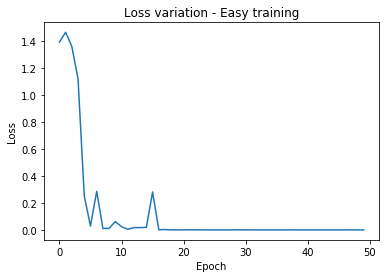

In [8]:
#joli plot du loss en fonction de l'epoch
import matplotlib.pyplot as plt
plt.plot(tempo, acc)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss variation - Easy training')
plt.savefig('Loss_easytraining.png')
plt.show()

Maintenant pour le set moyen, qui obtient 68% de précision :

Started training
Epoch: 1 [0/2000 (0%)]	Loss: 1.374355


/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 [200/2000 (10%)]	Loss: 1.359179
Epoch: 1 [400/2000 (20%)]	Loss: 1.361182
Epoch: 1 [600/2000 (30%)]	Loss: 1.358648
Epoch: 1 [800/2000 (40%)]	Loss: 1.468187
Epoch: 1 [1000/2000 (50%)]	Loss: 1.383861
Epoch: 1 [1200/2000 (60%)]	Loss: 1.454609
Epoch: 1 [1400/2000 (70%)]	Loss: 1.488600
Epoch: 1 [1600/2000 (80%)]	Loss: 1.515073
Epoch: 1 [1800/2000 (90%)]	Loss: 1.302717
Epoch: 2 [0/2000 (0%)]	Loss: 1.411291
Epoch: 2 [200/2000 (10%)]	Loss: 1.393153
Epoch: 2 [400/2000 (20%)]	Loss: 1.368572
Epoch: 2 [600/2000 (30%)]	Loss: 1.349585
Epoch: 2 [800/2000 (40%)]	Loss: 1.385220
Epoch: 2 [1000/2000 (50%)]	Loss: 1.368461
Epoch: 2 [1200/2000 (60%)]	Loss: 1.500476
Epoch: 2 [1400/2000 (70%)]	Loss: 1.377312
Epoch: 2 [1600/2000 (80%)]	Loss: 1.352135
Epoch: 2 [1800/2000 (90%)]	Loss: 1.387257
Epoch: 3 [0/2000 (0%)]	Loss: 1.343654
Epoch: 3 [200/2000 (10%)]	Loss: 1.390976
Epoch: 3 [400/2000 (20%)]	Loss: 1.431192
Epoch: 3 [600/2000 (30%)]	Loss: 1.356247
Epoch: 3 [800/2000 (40%)]	Loss: 1.370790
Epoch: 3 [10

Epoch: 20 [1600/2000 (80%)]	Loss: 0.630459
Epoch: 20 [1800/2000 (90%)]	Loss: 0.310293
Epoch: 21 [0/2000 (0%)]	Loss: 0.004555
Epoch: 21 [200/2000 (10%)]	Loss: 0.033740
Epoch: 21 [400/2000 (20%)]	Loss: 0.000157
Epoch: 21 [600/2000 (30%)]	Loss: 0.017312
Epoch: 21 [800/2000 (40%)]	Loss: 0.095727
Epoch: 21 [1000/2000 (50%)]	Loss: 0.016831
Epoch: 21 [1200/2000 (60%)]	Loss: 0.108910
Epoch: 21 [1400/2000 (70%)]	Loss: 0.029227
Epoch: 21 [1600/2000 (80%)]	Loss: 0.004114
Epoch: 21 [1800/2000 (90%)]	Loss: 0.043560
Epoch: 22 [0/2000 (0%)]	Loss: 0.162118
Epoch: 22 [200/2000 (10%)]	Loss: 0.543471
Epoch: 22 [400/2000 (20%)]	Loss: 0.261112
Epoch: 22 [600/2000 (30%)]	Loss: 0.170364
Epoch: 22 [800/2000 (40%)]	Loss: 0.067468
Epoch: 22 [1000/2000 (50%)]	Loss: 0.118763
Epoch: 22 [1200/2000 (60%)]	Loss: 0.012867
Epoch: 22 [1400/2000 (70%)]	Loss: 0.007751
Epoch: 22 [1600/2000 (80%)]	Loss: 0.007162
Epoch: 22 [1800/2000 (90%)]	Loss: 0.006162
Epoch: 23 [0/2000 (0%)]	Loss: 0.001961
Epoch: 23 [200/2000 (10%)]	Loss

Epoch: 40 [600/2000 (30%)]	Loss: 0.001077
Epoch: 40 [800/2000 (40%)]	Loss: 0.002099
Epoch: 40 [1000/2000 (50%)]	Loss: 0.003767
Epoch: 40 [1200/2000 (60%)]	Loss: 0.000171
Epoch: 40 [1400/2000 (70%)]	Loss: 0.001339
Epoch: 40 [1600/2000 (80%)]	Loss: 0.000316
Epoch: 40 [1800/2000 (90%)]	Loss: 0.002192
Epoch: 41 [0/2000 (0%)]	Loss: 0.000681
Epoch: 41 [200/2000 (10%)]	Loss: 0.000873
Epoch: 41 [400/2000 (20%)]	Loss: 0.002975
Epoch: 41 [600/2000 (30%)]	Loss: 0.002112
Epoch: 41 [800/2000 (40%)]	Loss: 0.000653
Epoch: 41 [1000/2000 (50%)]	Loss: 0.000048
Epoch: 41 [1200/2000 (60%)]	Loss: 0.000119
Epoch: 41 [1400/2000 (70%)]	Loss: 0.000177
Epoch: 41 [1600/2000 (80%)]	Loss: 0.000223
Epoch: 41 [1800/2000 (90%)]	Loss: 0.000169
Epoch: 42 [0/2000 (0%)]	Loss: 0.000381
Epoch: 42 [200/2000 (10%)]	Loss: 0.000830
Epoch: 42 [400/2000 (20%)]	Loss: 0.000081
Epoch: 42 [600/2000 (30%)]	Loss: 0.000031
Epoch: 42 [800/2000 (40%)]	Loss: 0.000075
Epoch: 42 [1000/2000 (50%)]	Loss: 0.000172
Epoch: 42 [1200/2000 (60%)]	L

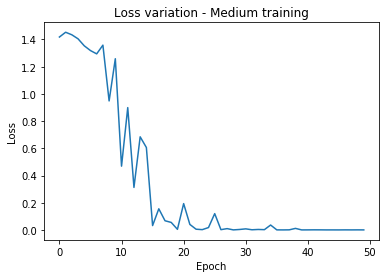

In [9]:
import torch
import torchvision
from torchvision import transforms, datasets

#Import
data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((32,32)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

train_set = datasets.ImageFolder(root='clouds_medium',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=4, shuffle=True,
                                             num_workers=1)

test_set = datasets.ImageFolder(root='clouds_medium_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=4,shuffle=False,
                                             num_workers=1)

cloud_classes = ('0', 'pi/4', 'pi/2', '3pi/4')

#Model
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(32 * 32, 200)
            self.fc2 = nn.Linear(200, 200)
            self.fc3 = nn.Linear(200, 4)

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return F.log_softmax(input=x)
model = Net()

#Optimizer
import torch.optim as optim
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

#Training
import time
start_time = time.time()
print("Started training")

epochs = 50
print_interval = 50
tempo = []
acc = []

for epoch in range(epochs):  
    for batch_idx, (data, target) in enumerate(train_loader): 
        data, target = Variable(data), Variable(target)

        data = data.view(-1, 32*32)

        optimizer.zero_grad()
        net_out = model(data)
        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()

        if batch_idx % print_interval == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.data[0]))
    tempo.append(epoch)
    acc.append(loss.data[0])
    
print("Finished training in  %.3f seconds " % (time.time() - start_time))

#Testing
test_loss = 0
correct = 0

for data, target in test_loader:
    data, target = Variable(data, volatile=True), Variable(target)
    
    data = data.view(-1, 32 * 32)
    net_out = model(data)
    
    test_loss += criterion(net_out, target).data[0]
    pred = net_out.data.max(1)[1]
    correct += pred.eq(target.data).sum() 

test_loss /= len(test_loader.dataset) 
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

#Saving
torch.save(model.state_dict(), "MODEL_trainMEDIUM_pytorchMCV2")

#Plotting
import matplotlib.pyplot as plt
plt.plot(tempo, acc)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss variation - Medium training')
plt.savefig('Loss_medtraining.png')
plt.show()

Et pour terminer avec le dur, précision de 45% :

Started training
Epoch: 1 [0/2000 (0%)]	Loss: 1.394337


/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 [200/2000 (10%)]	Loss: 1.403620
Epoch: 1 [400/2000 (20%)]	Loss: 1.489994
Epoch: 1 [600/2000 (30%)]	Loss: 1.381952
Epoch: 1 [800/2000 (40%)]	Loss: 1.343594
Epoch: 1 [1000/2000 (50%)]	Loss: 1.458528
Epoch: 1 [1200/2000 (60%)]	Loss: 1.420861
Epoch: 1 [1400/2000 (70%)]	Loss: 1.380307
Epoch: 1 [1600/2000 (80%)]	Loss: 1.419491
Epoch: 1 [1800/2000 (90%)]	Loss: 1.414714
Epoch: 2 [0/2000 (0%)]	Loss: 1.396639
Epoch: 2 [200/2000 (10%)]	Loss: 1.331998
Epoch: 2 [400/2000 (20%)]	Loss: 1.375875
Epoch: 2 [600/2000 (30%)]	Loss: 1.352540
Epoch: 2 [800/2000 (40%)]	Loss: 1.354452
Epoch: 2 [1000/2000 (50%)]	Loss: 1.447686
Epoch: 2 [1200/2000 (60%)]	Loss: 1.437636
Epoch: 2 [1400/2000 (70%)]	Loss: 1.347588
Epoch: 2 [1600/2000 (80%)]	Loss: 1.323403
Epoch: 2 [1800/2000 (90%)]	Loss: 1.399114
Epoch: 3 [0/2000 (0%)]	Loss: 1.284377
Epoch: 3 [200/2000 (10%)]	Loss: 1.388207
Epoch: 3 [400/2000 (20%)]	Loss: 1.395785
Epoch: 3 [600/2000 (30%)]	Loss: 1.378447
Epoch: 3 [800/2000 (40%)]	Loss: 1.382730
Epoch: 3 [10

Epoch: 20 [1600/2000 (80%)]	Loss: 0.303706
Epoch: 20 [1800/2000 (90%)]	Loss: 0.019550
Epoch: 21 [0/2000 (0%)]	Loss: 0.001746
Epoch: 21 [200/2000 (10%)]	Loss: 0.523292
Epoch: 21 [400/2000 (20%)]	Loss: 0.040975
Epoch: 21 [600/2000 (30%)]	Loss: 0.055294
Epoch: 21 [800/2000 (40%)]	Loss: 0.544001
Epoch: 21 [1000/2000 (50%)]	Loss: 0.316687
Epoch: 21 [1200/2000 (60%)]	Loss: 0.026984
Epoch: 21 [1400/2000 (70%)]	Loss: 0.136032
Epoch: 21 [1600/2000 (80%)]	Loss: 0.443502
Epoch: 21 [1800/2000 (90%)]	Loss: 0.670873
Epoch: 22 [0/2000 (0%)]	Loss: 0.833573
Epoch: 22 [200/2000 (10%)]	Loss: 0.048717
Epoch: 22 [400/2000 (20%)]	Loss: 1.043102
Epoch: 22 [600/2000 (30%)]	Loss: 0.038844
Epoch: 22 [800/2000 (40%)]	Loss: 0.329060
Epoch: 22 [1000/2000 (50%)]	Loss: 0.011750
Epoch: 22 [1200/2000 (60%)]	Loss: 0.036445
Epoch: 22 [1400/2000 (70%)]	Loss: 0.822783
Epoch: 22 [1600/2000 (80%)]	Loss: 0.038313
Epoch: 22 [1800/2000 (90%)]	Loss: 0.498139
Epoch: 23 [0/2000 (0%)]	Loss: 0.154353
Epoch: 23 [200/2000 (10%)]	Loss

Epoch: 40 [600/2000 (30%)]	Loss: 0.003644
Epoch: 40 [800/2000 (40%)]	Loss: 0.001426
Epoch: 40 [1000/2000 (50%)]	Loss: 0.000937
Epoch: 40 [1200/2000 (60%)]	Loss: 0.009073
Epoch: 40 [1400/2000 (70%)]	Loss: 0.000434
Epoch: 40 [1600/2000 (80%)]	Loss: 0.145900
Epoch: 40 [1800/2000 (90%)]	Loss: 0.101054
Epoch: 41 [0/2000 (0%)]	Loss: 0.020715
Epoch: 41 [200/2000 (10%)]	Loss: 0.001798
Epoch: 41 [400/2000 (20%)]	Loss: 0.013274
Epoch: 41 [600/2000 (30%)]	Loss: 0.001734
Epoch: 41 [800/2000 (40%)]	Loss: 0.063425
Epoch: 41 [1000/2000 (50%)]	Loss: 0.002083
Epoch: 41 [1200/2000 (60%)]	Loss: 0.000211
Epoch: 41 [1400/2000 (70%)]	Loss: 0.001660
Epoch: 41 [1600/2000 (80%)]	Loss: 0.000005
Epoch: 41 [1800/2000 (90%)]	Loss: 0.070718
Epoch: 42 [0/2000 (0%)]	Loss: 0.113709
Epoch: 42 [200/2000 (10%)]	Loss: 0.172816
Epoch: 42 [400/2000 (20%)]	Loss: 0.129520
Epoch: 42 [600/2000 (30%)]	Loss: 0.005254
Epoch: 42 [800/2000 (40%)]	Loss: 0.004954
Epoch: 42 [1000/2000 (50%)]	Loss: 0.052726
Epoch: 42 [1200/2000 (60%)]	L

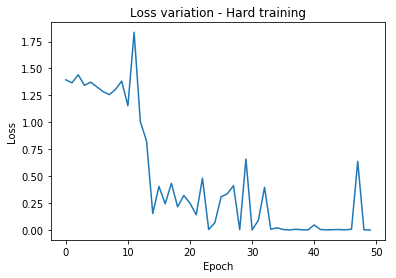

In [44]:
import torch
import torchvision
from torchvision import transforms, datasets

#Import
data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((32,32)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

train_set = datasets.ImageFolder(root='clouds_hard',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=4, shuffle=True,
                                             num_workers=1)

test_set = datasets.ImageFolder(root='clouds_hard_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=4,shuffle=False,
                                             num_workers=1)

cloud_classes = ('0', 'pi/4', 'pi/2', '3pi/4')

#Model
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(32 * 32, 200)
            self.fc2 = nn.Linear(200, 200)
            self.fc3 = nn.Linear(200, 4)

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return F.log_softmax(input=x)
model = Net()

#Optimizer
import torch.optim as optim
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

#Training
import time
start_time = time.time()
print("Started training")

epochs = 50
print_interval = 50
tempo = []
acc = []

for epoch in range(epochs):  
    for batch_idx, (data, target) in enumerate(train_loader): 
        data, target = Variable(data), Variable(target)

        data = data.view(-1, 32*32)

        optimizer.zero_grad()
        net_out = model(data)
        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()

        if batch_idx % print_interval == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.data[0]))
    tempo.append(epoch)
    acc.append(loss.data[0])
    
print("Finished training in  %.3f seconds " % (time.time() - start_time))

#Testing
test_loss = 0
correct = 0

for data, target in test_loader:
    data, target = Variable(data, volatile=True), Variable(target)
    
    data = data.view(-1, 32 * 32)
    net_out = model(data)
    
    test_loss += criterion(net_out, target).data[0]
    pred = net_out.data.max(1)[1]
    correct += pred.eq(target.data).sum() 

test_loss /= len(test_loader.dataset) 
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

#Saving
torch.save(model.state_dict(), "MODEL_trainHARD_pytorchMCV2")

#Plotting
import matplotlib.pyplot as plt
plt.plot(tempo, acc)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss variation - Hard training')
plt.savefig('Loss_hardtraining.png')
plt.show()